# Sentiment analysis media cloud extrated data

This notebook implements a foundational Sentiment Analysis pipeline on news titles, addressing the constraint of no labeled training data. We use the VADER lexicon method for classification and demonstrate feature engineering using TF-IDF and Truncated SVD (LSA) for future-proofing and exploration.

In [19]:
# Core Libraries
import pandas as pd
import re
import numpy as np

# Sentiment Analysis (Lexicon)
from transformers import pipeline

# Feature Extraction and Dimensionality Reduction (ML components)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# vizualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

# --- Sample Newspaper Titles Data ---
media_cloud = pd.read_csv("../data/orientaion_english.csv") 
media_cloud.head()

,id,indexed_date,language,media_name,media_url,publish_date,title,url,domain,political_orientation
0,8ec6ee3fbd7df8acf011807509135594e1059a975e4e33...,2025-12-07 21:29:31.704001+00:00,es,bbc.com,bbc.com,07/12/2025,Fujian: what is the next-generation aircraft c...,https://www.bbc.com/mundo/articles/cdd526n2egr...,bbc.com,center
1,c4b7fc0a14d38d4bb082aac6ab793cb70ffbdce43fcab0...,2025-11-23 21:29:39.700224+00:00,es,bbc.com,bbc.com,23/11/2025,How Australia wants to prohibit access to soci...,https://www.bbc.com/mundo/articles/cx202xn46jl...,bbc.com,center
2,834718f13edd76254b40b505b7569e20f9e5fe5eb4849a...,2025-10-20 05:23:29.155237+00:00,en,correiobraziliense.com.br,correiobraziliense.com.br,19/10/2025,Trump publica vÃ­deo de IA com ataque de fezes...,https://www.correiobraziliense.com.br/mundo/20...,correiobraziliense.com.br,center
3,cf5195fa34510410a88564813fa464cc235dcf8cd7d0a5...,2025-09-14 21:27:48.971495+00:00,es,bbc.com,bbc.com,14/09/2025,The millionaires of Silicon Valley have messia...,https://www.bbc.com/mundo/articles/c701420e172...,bbc.com,center
4,0b1ce86ab0a7bf3f1705d8a076c0021119daeeebb6f718...,2025-09-02 21:31:52.015017+00:00,es,bbc.com,bbc.com,02/09/2025,"Tatiana Bilbao: ""Architecture can be a platfor...",https://www.bbc.com/mundo/articles/c5yp28n4n65...,bbc.com,center


In [4]:
#let's conduct a sanity check on the data
print(media_cloud["language"].value_counts())

language
en    58164
es    22557
pt    12072
tr     3086
it     2138
fr     1664
uk      850
ru      819
nl      804
de      766
pl      158
Name: count, dtype: int64


# Core Sentiment Classification

In [7]:
analyzer = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english")

Device set to use mps:0


In [8]:
tokenizer = analyzer.tokenizer

def count_tokens(text):
    if not isinstance(text, str): return 0
    return len(tokenizer.encode(text, add_special_tokens=True))

# Find the exact token counts
media_cloud['token_count'] = media_cloud['title'].apply(count_tokens)

# Locate the exact row from your error message, the maximum token count for the model is 514
the_culprit = media_cloud[media_cloud['token_count'] == 3385]
print(the_culprit)

Token indices sequence length is longer than the specified maximum sequence length for this model (3385 > 512). Running this sequence through the model will result in indexing errors


                                                      id  \
95007  2a5a7eeda969d5f2bff3119c3f0799a240525b2e2feb17...   

                           indexed_date language    media_name     media_url  \
95007  2024-12-05 20:22:33.961162+00:00       pt  ubaitaba.com  ubaitaba.com   

      publish_date                                              title  \
95007   2024-12-05  Comissão aprova por unanimidade o marco regula...   

                                                     url        domain  \
95007  http://ubaitaba.com/comissao-aprova-por-unanim...  ubaitaba.com   

      political_orientation  token_count  
95007                center         3385  


In [9]:
media_cloud.drop(media_cloud.index[95007], inplace=True)

In [10]:
# 1. Initialize the general sentiment analyzer



def get_sentiment(text):
    # Pass the text directly—no target needed!
    result = analyzer(text)
    return result[0]['label']



media_cloud['Sentiment_Label'] = media_cloud['title'].apply(get_sentiment)



In [11]:
def classify_sentiment(label):
    # This is simple binary classification
    return 'Positive' if label == 'POSITIVE' else 'Negative' if label == 'NEGATIVE' else 'UK'

media_cloud['Sentiment_RoBERTa'] = media_cloud['Sentiment_Label'].apply(classify_sentiment)
print("--- Sentiment Analysis Results (RoBERTa) ---")
print(media_cloud[['title', 'Sentiment_Label', 'Sentiment_RoBERTa']])

--- Sentiment Analysis Results (RoBERTa) ---
                                                    title Sentiment_Label  \
0       Fujian: what is the next-generation aircraft c...        POSITIVE   
1       How Australia wants to prohibit access to soci...        NEGATIVE   
2       Trump publica vÃ­deo de IA com ataque de fezes...        NEGATIVE   
3       The millionaires of Silicon Valley have messia...        NEGATIVE   
4       Tatiana Bilbao: "Architecture can be a platfor...        POSITIVE   
...                                                   ...             ...   
103073  Scientists point out risks and benefits of art...        POSITIVE   
103074  Academy sees risks and benefits of artificial ...        POSITIVE   
103075  How Brazil can take advantage of the artificia...        POSITIVE   
103076  Artificial intelligence: Brazil could miss the...        NEGATIVE   
103077  American CVM faces resistance to plan to regul...        NEGATIVE   

       Sentiment_RoBERTa  
0  

In [13]:
# let's save the updated DataFrame into a new CSV file
media_cloud.to_csv("../data/analysis.csv", index=False)

# Preprocessing and text cleaning for TFI-DF

In [12]:
def clean_text(text):
    # 1. Lowercasing (Standard practice for normalization)
    text = text.lower()
    # 2. Remove text inside parentheses (often non-essential context in titles)
    text = re.sub(r'\([^)]*\)', '', text)
    # 3. Remove most punctuation, but KEEP VADER-relevant symbols (like ! and ?)
    # VADER is explicitly designed to use punctuation (!!!) and capitalization (ALL CAPS)
    # as intensifiers. We will clean for the *TF-IDF* features but keep the raw
    # title for VADER, which is why we create a separate 'Clean_Title' column.
    return text

# We will create a clean version for feature extraction (TF-IDF)
media_cloud['clean_title'] = media_cloud['title'].apply(clean_text)

# Post-Classification Exploration and Feature Engineering

In [14]:
# Vectorize the CLEANED text
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
tfidf_matrix = vectorizer.fit_transform(media_cloud['clean_title'])
feature_names = vectorizer.get_feature_names_out()

print("TF-IDF Vectorization Complete.")
print(f"Shape of TF-IDF Matrix (Rows: Titles, Columns: Features): {tfidf_matrix.shape}")

TF-IDF Vectorization Complete.
Shape of TF-IDF Matrix (Rows: Titles, Columns: Features): (103077, 403603)


In [15]:
# Reduce dimensions to 2 components for ease of inspection
svd = TruncatedSVD(n_components=2, random_state=42)
lsa_result = svd.fit_transform(tfidf_matrix)

media_cloud['LSA_Component_1'] = lsa_result[:, 0]
media_cloud['LSA_Component_2'] = lsa_result[:, 1]

print("\n--- Exploration: LSA Components and Sentiment ---")
print(media_cloud[['Sentiment_RoBERTa', 'LSA_Component_1', 'LSA_Component_2']])

# Look at the top features that define the discovered LSA components (the 'topics')
print("\nTop features defining the LSA Components (Inferred Topics):")
for i, comp in enumerate(svd.components_):
    # Get the top 5 words/n-grams that contribute most to this component
    sorted_idx = comp.argsort()[::-1][:5]
    top_words = [feature_names[j] for j in sorted_idx]
    print(f"Component {i+1}: {top_words}")


--- Exploration: LSA Components and Sentiment ---
       Sentiment_RoBERTa  LSA_Component_1  LSA_Component_2
0               Positive         0.003541         0.013469
1               Negative         0.008847         0.027513
2               Negative         0.001736         0.009831
3               Negative         0.003373         0.010625
4               Positive         0.000741         0.003026
...                  ...              ...              ...
103073          Positive         0.211795        -0.020599
103074          Positive         0.201800        -0.018875
103075          Positive         0.268740        -0.028956
103076          Negative         0.210035        -0.025023
103077          Negative         0.019815         0.085222

[103077 rows x 3 columns]

Top features defining the LSA Components (Inferred Topics):
Component 1: ['artificial', 'intelligence', 'artificial intelligence', 'regulation', 'regulation artificial']
Component 2: ['ai', 'regulation', 'tech', '

/opt/miniconda3/envs/Epochtest/lib/python3.11/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/opt/miniconda3/envs/Epochtest/lib/python3.11/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/opt/miniconda3/envs/Epochtest/lib/python3.11/site-packages/sklearn/utils/extmath.py:590: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


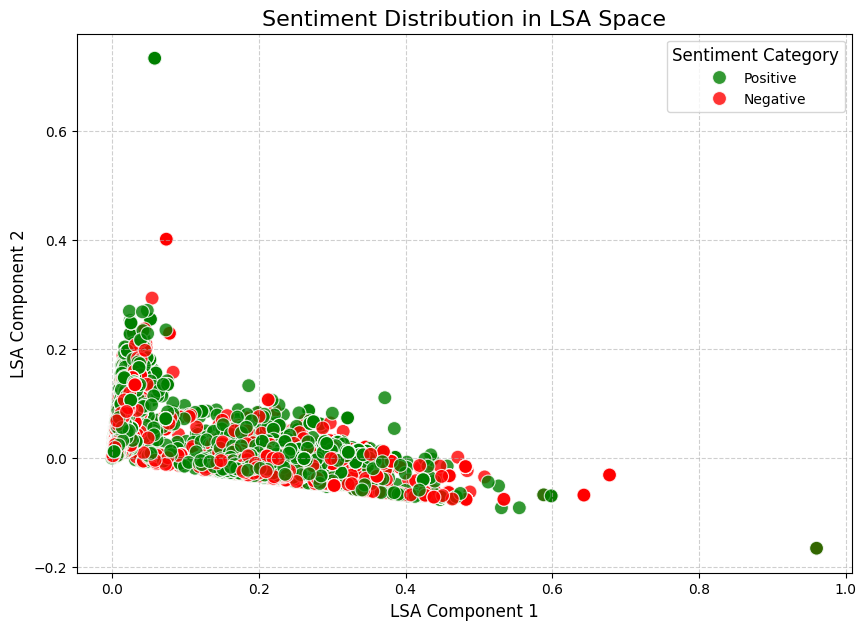

In [16]:
# 3. Visualization of LSA Components by Sentiment
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='LSA_Component_1',
    y='LSA_Component_2',
    hue='Sentiment_RoBERTa',  # Color points by sentiment
    data=media_cloud,
    s=100, # Size of points
    alpha=0.8, # Transparency
    palette={'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'} # Custom colors
)

# Add titles for clarity
plt.title('Sentiment Distribution in LSA Space', fontsize=16)
plt.xlabel('LSA Component 1', fontsize=12)
plt.ylabel('LSA Component 2', fontsize=12)

# Ensure the legend is displayed clearly
plt.legend(title='Sentiment Category', title_fontsize='12', fontsize='10')

plt.grid(True, linestyle='--', alpha=0.6)


plt.show()

In [20]:
# Compute mean TF-IDF per sentiment (sparse-safe for large datasets)
grouped = {}
for sentiment, idx_labels in media_cloud.groupby('Sentiment_RoBERTa').groups.items():
    pos = media_cloud.index.get_indexer(list(idx_labels))
    sub = tfidf_matrix[pos]
    mean_vec = sub.mean(axis=0)
    grouped[sentiment] = pd.Series(np.asarray(mean_vec).ravel(), index=feature_names)
grouped_tfidf = pd.DataFrame(grouped).T

In [21]:
for sentiment in grouped_tfidf.index:
    top_words = grouped_tfidf.loc[sentiment].sort_values(ascending=False).head(10)
    print(f"\nTop TF-IDF words for {sentiment} sentiment:")
    print(top_words)



Top TF-IDF words for Negative sentiment:
ai                         0.018798
artificial                 0.011075
intelligence               0.011044
artificial intelligence    0.010886
trump                      0.007598
regulation                 0.005897
says                       0.005761
tech                       0.005651
china                      0.005453
new                        0.005296
Name: Negative, dtype: float64

Top TF-IDF words for Positive sentiment:
ai                         0.018616
intelligence               0.010034
artificial                 0.009829
artificial intelligence    0.009799
market                     0.007302
new                        0.006849
global                     0.005502
digital                    0.005140
world                      0.004580
regulation                 0.004491
Name: Positive, dtype: float64


# Let's see how this results change according to each year

we first create different datasets where the filter is the year

and we do the same analysis done above

In [22]:
media_cloud['publish_date'] = pd.to_datetime(media_cloud.get('publish_date', media_cloud.get('date', None)), errors='coerce')
media_cloud['year'] = media_cloud['publish_date'].dt.year


/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_87619/28030670.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


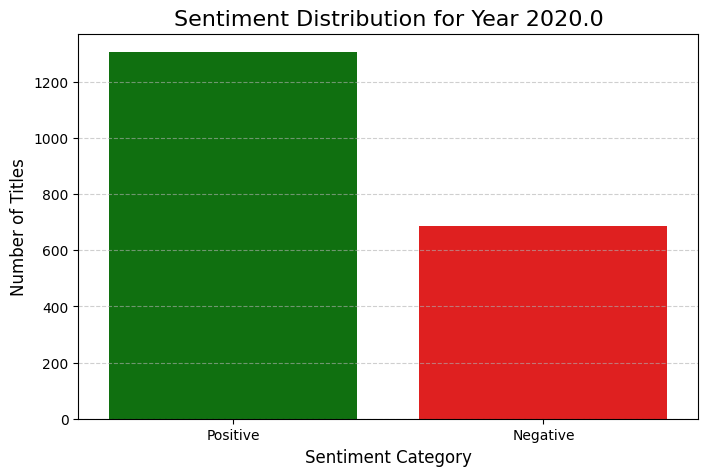


Year 2020.0 - Top TF-IDF words for Negative sentiment:
facial                0.019162
facial recognition    0.019025
recognition           0.018888
coronavirus           0.013709
trump                 0.009707
tech                  0.009211
tiktok                0.008651
social                0.008490
social media          0.008360
media                 0.008164
Name: Negative, dtype: float64

Year 2020.0 - Top TF-IDF words for Positive sentiment:
coronavirus            0.016835
coronavirus spain      0.014424
spain today            0.014397
2020                   0.013873
today                  0.012278
house proposes         0.011510
spain                  0.011432
ai                     0.010780
white house            0.009436
proposes guidelines    0.009314
Name: Positive, dtype: float64


/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_87619/28030670.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


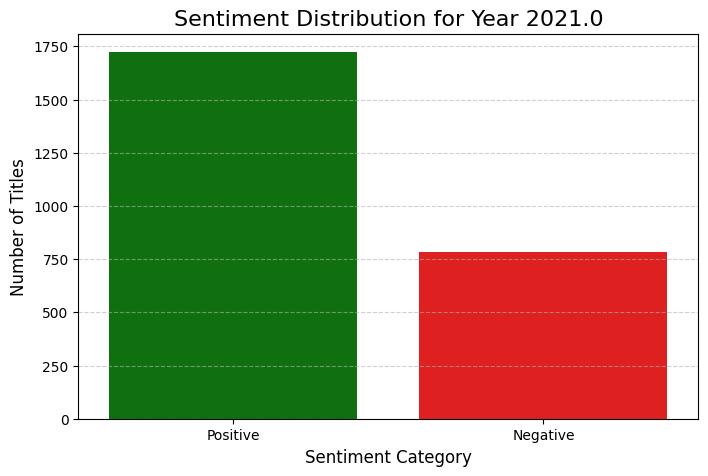


Year 2021.0 - Top TF-IDF words for Negative sentiment:
facebook              0.023999
china                 0.014524
facial                0.013333
facial recognition    0.013287
recognition           0.013286
privacy               0.010673
algorithms            0.008443
tech                  0.007921
algorithms make       0.007659
make believe          0.007659
Name: Negative, dtype: float64

Year 2021.0 - Top TF-IDF words for Positive sentiment:
2021          0.018693
market        0.011029
global        0.010305
announces     0.009227
ai            0.008454
technology    0.007453
digital       0.006850
data          0.006825
new           0.006248
tech          0.005352
Name: Positive, dtype: float64


/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_87619/28030670.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


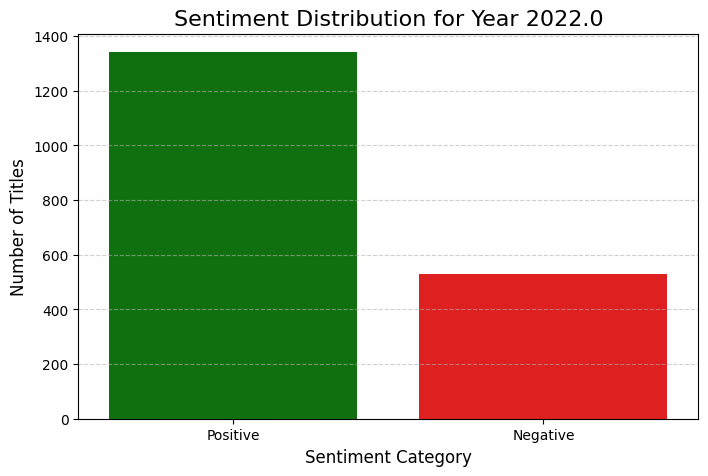


Year 2022.0 - Top TF-IDF words for Negative sentiment:
big                       0.013382
tech                      0.012492
pornographic deepfakes    0.011857
big tech                  0.011820
pornographic              0.011339
efforts                   0.011029
twitter                   0.010546
efforts rein              0.009521
rein big                  0.009521
ruling                    0.009513
Name: Negative, dtype: float64

Year 2022.0 - Top TF-IDF words for Positive sentiment:
2022                       0.021031
market                     0.015567
announces                  0.008967
financial                  0.007568
size                       0.007539
results                    0.007535
intelligence               0.007165
artificial intelligence    0.006969
artificial                 0.006946
data                       0.006817
Name: Positive, dtype: float64


/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_87619/28030670.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


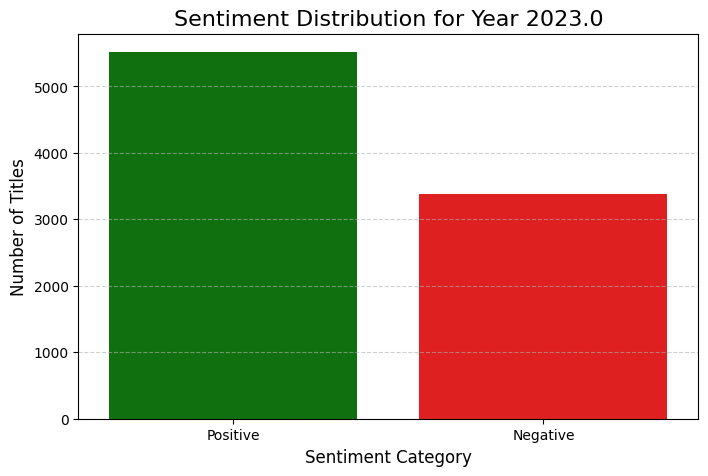


Year 2023.0 - Top TF-IDF words for Negative sentiment:
ai                         0.026600
artificial                 0.016804
intelligence               0.016717
artificial intelligence    0.016669
chatgpt                    0.009785
regulate                   0.008557
regulation                 0.007432
china                      0.007154
says                       0.006744
new                        0.005134
Name: Negative, dtype: float64

Year 2023.0 - Top TF-IDF words for Positive sentiment:
ai                         0.028427
intelligence               0.015282
artificial                 0.015176
artificial intelligence    0.015164
world                      0.007825
eu                         0.007760
global                     0.007719
summit                     0.007355
2023                       0.006810
market                     0.006746
Name: Positive, dtype: float64


/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_87619/28030670.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


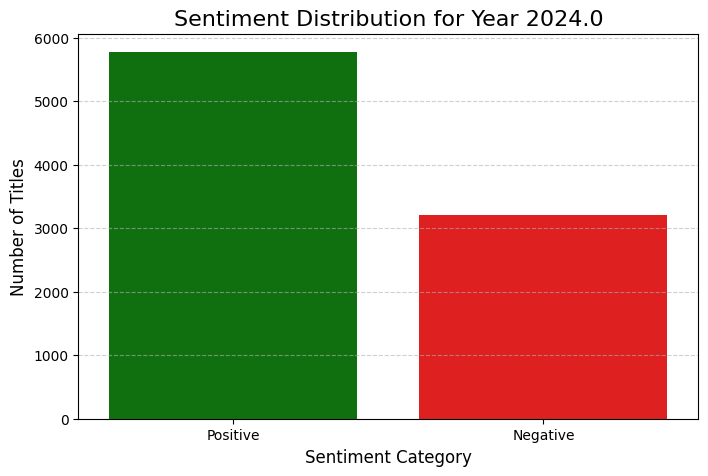


Year 2024.0 - Top TF-IDF words for Negative sentiment:
ai                         0.018065
artificial                 0.010013
artificial intelligence    0.009885
intelligence               0.009849
china                      0.007821
trump                      0.006696
regulation                 0.006161
review mec                 0.004747
tension review             0.004747
china tension              0.004719
Name: Negative, dtype: float64

Year 2024.0 - Top TF-IDF words for Positive sentiment:
ai                         0.020516
2024                       0.012161
intelligence               0.009603
artificial                 0.009414
artificial intelligence    0.009375
new                        0.007155
trump                      0.006435
market                     0.006183
world                      0.005381
tech                       0.004886
Name: Positive, dtype: float64


/var/folders/s7/06176ck52670b55rv_lly5980000gn/T/ipykernel_87619/28030670.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


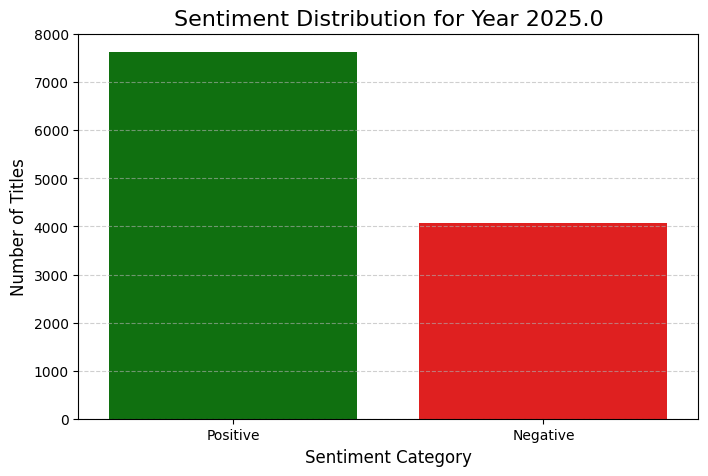


Year 2025.0 - Top TF-IDF words for Negative sentiment:
ai                         0.022333
trump                      0.019467
intelligence               0.007829
artificial                 0.007811
artificial intelligence    0.007760
new                        0.006600
order                      0.006332
ban                        0.006285
regulation                 0.006254
musk                       0.005937
Name: Negative, dtype: float64

Year 2025.0 - Top TF-IDF words for Positive sentiment:
ai                         0.021159
2025                       0.012400
market                     0.008156
new                        0.007655
intelligence               0.007293
artificial intelligence    0.007031
artificial                 0.007027
announces                  0.006960
summit                     0.006737
global                     0.006330
Name: Positive, dtype: float64


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Filter the entire dataframe first (Optional, but cleaner)
# media_cloud = media_cloud[media_cloud['Sentiment_RoBERTa'].isin(['Positive', 'Negative'])]

for year in sorted(media_cloud['year'].dropna().unique()):
    # Filter by year
    yearly_data = media_cloud[media_cloud['year'] == year].copy()
    
    # --- ADDED FILTER: Keep only Positive and Negative ---
    yearly_data = yearly_data[yearly_data['Sentiment_RoBERTa'].isin(['Positive', 'Negative'])]
    
    if yearly_data.empty:
        continue

    # Distribution plot - Removed Neutral from order and palette
    plt.figure(figsize=(8, 5))
    sns.countplot(
        x='Sentiment_RoBERTa', 
        data=yearly_data, 
        order=['Positive', 'Negative'], # Removed 'Neutral'
        palette={'Positive': 'green', 'Negative': 'red'} # Removed 'Neutral'
    )
    plt.title(f'Sentiment Distribution for Year {year}', fontsize=16)
    plt.xlabel('Sentiment Category', fontsize=12)
    plt.ylabel('Number of Titles', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

    # Transform YEARLY cleaned titles
    yearly_tfidf = vectorizer.transform(yearly_data['clean_title'])

    # Compute mean TF-IDF per sentiment
    if yearly_tfidf.shape[0] <= 5000:
        tfidf_df = pd.DataFrame(yearly_tfidf.toarray(), columns=feature_names, index=yearly_data.index)
        tfidf_df['Sentiment_RoBERTa'] = yearly_data['Sentiment_RoBERTa'].values
        grouped_tfidf = tfidf_df.groupby('Sentiment_RoBERTa').mean()
    else:
        grouped = {}
        for sentiment, idx_labels in yearly_data.groupby('Sentiment_RoBERTa').groups.items():
            pos = yearly_data.index.get_indexer(list(idx_labels))
            sub = yearly_tfidf[pos]
            mean_vec = sub.mean(axis=0)
            grouped[sentiment] = pd.Series(np.asarray(mean_vec).ravel(), index=feature_names)
        grouped_tfidf = pd.DataFrame(grouped).T

    # Print top words per sentiment
    for sentiment in grouped_tfidf.index:
        # This will now only loop through 'Positive' and 'Negative'
        top_words = grouped_tfidf.loc[sentiment].sort_values(ascending=False).head(10)
        print(f"\nYear {year} - Top TF-IDF words for {sentiment} sentiment:")
        print(top_words)

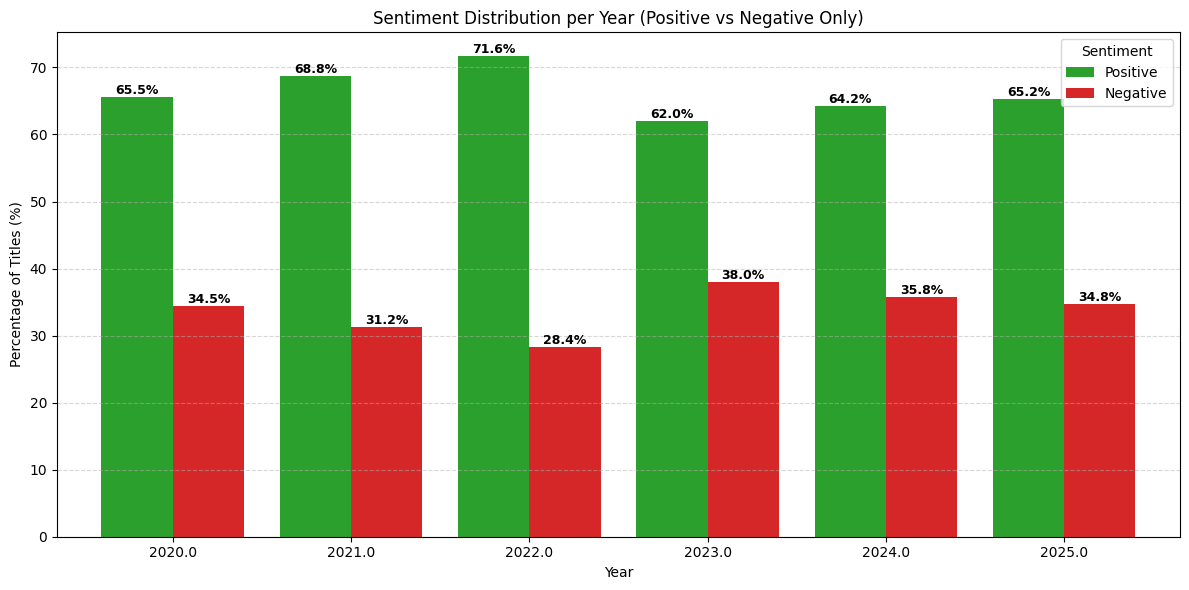

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Update the order to exclude 'Neutral'
sentiments_order = ['Positive', 'Negative']

# 2. Compute counts per year x sentiment
counts = media_cloud.groupby(['year', 'Sentiment_RoBERTa']).size().unstack(fill_value=0)

# 3. CRITICAL: Select only Positive and Negative columns
# This removes 'Neutral' and ensures the sum for percentages only includes these two
counts = counts.reindex(columns=sentiments_order, fill_value=0)

# 4. Compute percentages (now Positive + Negative = 100%)
counts_pct = counts.div(counts.sum(axis=1), axis=0) * 100

# 5. Plot grouped bars (Updated colors to match the two categories)
# Using Green for Positive and Red/Orange for Negative
ax = counts_pct.plot(kind='bar', figsize=(12, 6), width=0.8, color=['#2ca02c', '#d62728']) 

ax.set_ylabel('Percentage of Titles (%)')
ax.set_xlabel('Year')
ax.set_title('Sentiment Distribution per Year (Positive vs Negative Only)')
ax.legend(title='Sentiment', loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)

# 6. Annotate bars with percentage values
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# analysis of sentiment across outlets of the same political leaning

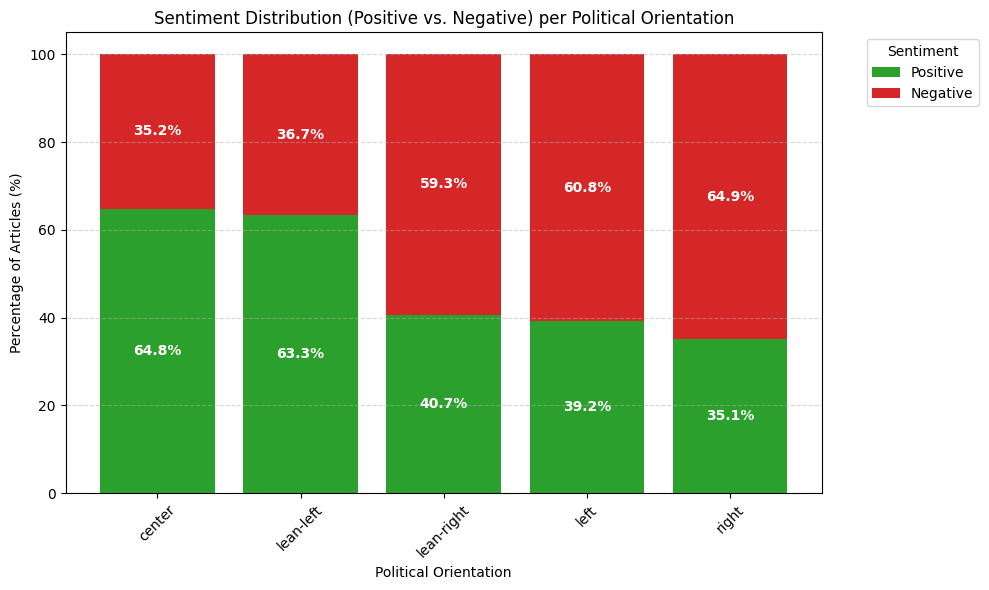

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Prepare and calculate sentiment counts
count_df = media_cloud.groupby(['political_orientation', 'Sentiment_RoBERTa']).size().unstack(fill_value=0)

# 2. CRITICAL: Filter to only Positive and Negative before calculating percentages
# This forces the sum of these two to be the 100% baseline
count_df = count_df[['Positive', 'Negative']]

# 3. Calculate percentages per political orientation
perc_df = count_df.div(count_df.sum(axis=1), axis=0) * 100

# 4. Define colors (Removed Neutral)
colors = {'Positive': '#2ca02c', 'Negative': '#d62728'} # Using a clearer Red for Negative

fig, ax = plt.subplots(figsize=(10, 6))

bottom = np.zeros(len(perc_df))
orientations = perc_df.index

# 5. Plot stacked bars for Positive and Negative only
for sentiment in ['Positive', 'Negative']:
    values = perc_df[sentiment].values
    bars = ax.bar(orientations, values, bottom=bottom, color=colors[sentiment], label=sentiment)
    
    # Annotate with percentage inside each segment
    for bar, pct in zip(bars, values):
        if pct > 5:  # annotate only if segment is large enough to see the text
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2,
                    f'{pct:.1f}%', ha='center', va='center', 
                    color='white', fontsize=10, fontweight='bold')
    
    bottom += values

ax.set_ylabel('Percentage of Articles (%)')
ax.set_xlabel('Political Orientation')
ax.set_title('Sentiment Distribution (Positive vs. Negative) per Political Orientation')
ax.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

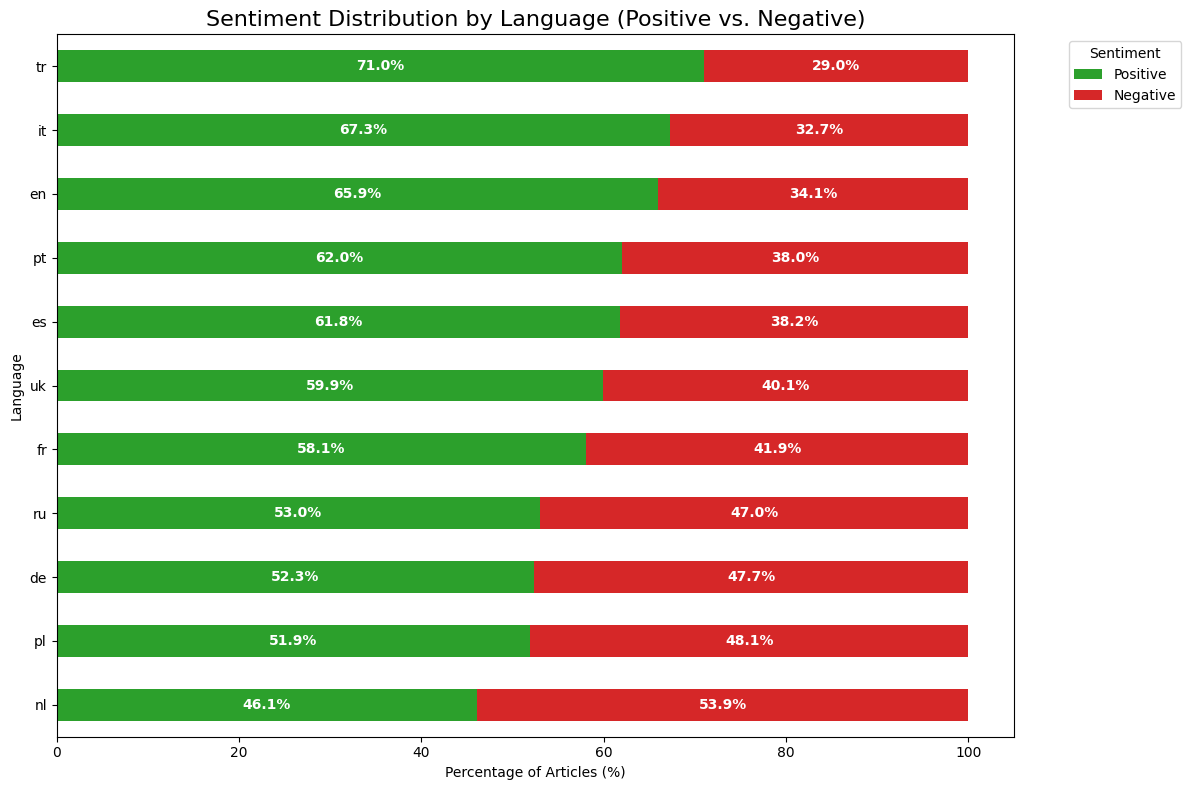

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Group by language and sentiment
# Replace 'language' with the actual column name in your dataframe if it differs
lang_sentiment = media_cloud.groupby(['language', 'Sentiment_RoBERTa']).size().unstack(fill_value=0)

# 2. Filter for only Positive and Negative
# We ignore Neutral so the binary comparison equals 100%
if 'Positive' in lang_sentiment.columns and 'Negative' in lang_sentiment.columns:
    lang_sentiment = lang_sentiment[['Positive', 'Negative']]
else:
    print("Warning: One of the required sentiment labels is missing from the data.")

# 3. Calculate percentages
lang_perc = lang_sentiment.div(lang_sentiment.sum(axis=1), axis=0) * 100

# 4. Sort by Positive sentiment to make the chart easier to read
lang_perc = lang_perc.sort_values(by='Positive', ascending=True)

# 5. Plotting
fig, ax = plt.subplots(figsize=(12, 8))
colors = {'Positive': '#2ca02c', 'Negative': '#d62728'}

# Plot horizontal bars
lang_perc.plot(kind='barh', stacked=True, color=[colors['Positive'], colors['Negative']], ax=ax)

# 6. Add percentage annotations inside the bars
for p in ax.patches:
    width = p.get_width()
    if width > 5:  # Only show text if the segment is wide enough
        ax.text(p.get_x() + width/2, p.get_y() + p.get_height()/2, 
                f'{width:.1f}%', va='center', ha='center', 
                color='white', fontsize=10, fontweight='bold')

ax.set_title('Sentiment Distribution by Language (Positive vs. Negative)', fontsize=16)
ax.set_xlabel('Percentage of Articles (%)')
ax.set_ylabel('Language')
ax.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()